In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
tmp = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')
tmp.head()

,timestamp,min,max,mean
0,1/1/2017 5:00,-1.911244,4.505489,1.699496
1,1/1/2017 6:00,-3.370600,4.495117,1.092577
2,1/1/2017 7:00,-3.582800,4.276133,0.964174
3,1/1/2017 8:00,-3.881800,3.711483,0.824071
4,1/1/2017 9:00,-4.742200,3.108950,0.266976


In [3]:
hum = pd.read_csv('Beehive Metrics Dataset/humidity_2017.csv')
hum.head()

,timestamp,humidity
0,2017-01-01 05:00:00,92.406667
1,2017-01-01 06:00:00,92.270000
2,2017-01-01 07:00:00,92.575000
3,2017-01-01 08:00:00,92.840000
4,2017-01-01 09:00:00,93.640000


In [4]:
flow = pd.read_csv('Beehive Metrics Dataset/new_flow_2017.csv')
flow.head()

,timestamp,out,in
0,1/1/2017 5:15,0,0
1,1/1/2017 5:16,0,0
2,1/1/2017 5:17,0,0
3,1/1/2017 5:18,0,0
4,1/1/2017 5:19,0,0


In [5]:
weight = pd.read_csv('Beehive Metrics Dataset/weight_2017.csv')
weight.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [6]:
#Change the timestamp fields to the datetime data type
tmp['timestamp'] = pd.to_datetime(tmp['timestamp'])
hum['timestamp'] = pd.to_datetime(hum['timestamp'])
flow['timestamp'] = pd.to_datetime(flow['timestamp'])
weight['timestamp'] = pd.to_datetime(weight['timestamp'])

In [7]:
#Check the datatypes
tmp.info()
hum.info()
flow.info()
weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104821 entries, 0 to 104820
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  104821 non-null  datetime64[ns]
 1   min        104821 non-null  float64       
 2   max        104821 non-null  float64       
 3   mean       104821 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8737 non-null   datetime64[ns]
 1   humidity   8737 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 136.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524050 entries, 0 to 524049
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------

In [8]:
#Count blanks or whitespaces
tmp = tmp.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
tmp.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [9]:
hum = hum.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
hum.isnull().sum()

timestamp    0
humidity     0
dtype: int64

In [10]:
flow = flow.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
flow.isnull().sum()

timestamp    0
out          0
in           0
dtype: int64

In [11]:
weight = weight.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
weight.isnull().sum()

timestamp    0
weight       0
dtype: int64

In [12]:
#Merge humidity and temp together
tmpdf = hum.merge(tmp, how='left', on='timestamp')
tmpdf.head(20)

,timestamp,humidity,min,max,mean
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033


In [13]:
#Merge flow in
tmpdf2 = tmpdf.merge(flow, how='left', on='timestamp')
tmpdf2.head(20)

,timestamp,humidity,min,max,mean,out,in
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0


In [14]:
#Merge weight in
df = tmpdf2.merge(weight, how='left', on='timestamp')
df.head(20)

,timestamp,humidity,min,max,mean,out,in,weight
0,2017-01-01 05:00:00,92.406667,-1.911244,4.505489,1.699496,NaN,NaN,NaN
1,2017-01-01 06:00:00,92.270000,-3.370600,4.495117,1.092577,0.0,0.0,52.6972
2,2017-01-01 07:00:00,92.575000,-3.582800,4.276133,0.964174,0.0,0.0,52.6972
3,2017-01-01 08:00:00,92.840000,-3.881800,3.711483,0.824071,0.0,0.0,52.6652
4,2017-01-01 09:00:00,93.640000,-4.742200,3.108950,0.266976,0.0,0.0,52.6652
5,2017-01-01 10:00:00,93.768333,-4.717000,3.360517,0.107223,0.0,0.0,52.4731
6,2017-01-01 11:00:00,92.950000,-3.403800,5.602583,0.618697,0.0,0.0,52.4091
7,2017-01-01 12:00:00,92.080000,-2.767800,4.588617,0.892183,0.0,0.0,52.5051
8,2017-01-01 13:00:00,91.356667,-2.127200,4.864967,1.330385,0.0,0.0,52.6332
9,2017-01-01 14:00:00,91.071667,-1.635800,5.755283,1.723033,0.0,0.0,52.6972


In [15]:
#Looks like we got some nulls in there somewhere along the line
df.isnull().sum()

timestamp    0
humidity     0
min          0
max          0
mean         0
out          1
in           1
weight       1
dtype: int64

In [16]:
df.dropna(inplace = True)

In [17]:
df.reset_index(drop = True, inplace=True)

In [18]:
#Let's see if limiting the time to the spring-summer changes anything
#df.drop(df.loc[df['timestamp']<"2017-04-01"].index, inplace = True)
#df.drop(df.loc[df['timestamp']>"2017-10-01"].index, inplace = True)

In [19]:
#Show off the temp changes
#df.plot(x='timestamp', y=['mean','min','max'])

In [20]:
def checkID(row):
    if row == 0:
        return True
    else:
        return False

In [21]:
#Creating the column for change in weight
df['weightchange'] = df.apply(lambda currRow: 0 if checkID(int(currRow.name)) else (currRow.weight - float(df.iloc[int(currRow.name) - 1, 7])), axis = 1)
#df.apply(lambda x: print(str(x.name) + " " + str(x.weight)), axis = 1)
df

,timestamp,humidity,min,max,mean,out,in,weight,weightchange
0,2017-01-01 06:00:00,92.270000,-3.3706,4.495117,1.092577,0.0,0.0,52.6972,0.0000
1,2017-01-01 07:00:00,92.575000,-3.5828,4.276133,0.964174,0.0,0.0,52.6972,0.0000
2,2017-01-01 08:00:00,92.840000,-3.8818,3.711483,0.824071,0.0,0.0,52.6652,-0.0320
3,2017-01-01 09:00:00,93.640000,-4.7422,3.108950,0.266976,0.0,0.0,52.6652,0.0000
4,2017-01-01 10:00:00,93.768333,-4.7170,3.360517,0.107223,0.0,0.0,52.4731,-0.1921
...,...,...,...,...,...,...,...,...,...
8733,2017-12-31 01:00:00,90.255000,10.3460,19.169333,14.246423,0.0,0.0,53.6574,-0.0320
8734,2017-12-31 02:00:00,91.685000,9.9300,19.855500,14.212385,0.0,0.0,53.7214,0.0640
8735,2017-12-31 03:00:00,92.323333,9.8000,19.935333,14.322692,0.0,0.0,53.6574,-0.0640
8736,2017-12-31 04:00:00,92.675000,10.0100,19.812000,14.597641,0.0,0.0,53.6574,0.0000


In [22]:
#Check for and remove outliers in each column
for col in ['humidity', 'min', 'max', 'mean', 'weight', 'weightchange']:
    print(col)
    if col == "humidity":
        #Just checking for humidity values <0 or >100
        print(df.loc[(df[col]<0) | (df[col]> 100)], "\n")
        df.drop(df.loc[(df[col]<0) | (df[col]> 100)].index, inplace = True)
    elif col == "temperature":
        #Just making sure temp is in a good range, lets say >-10 and <110 farenheit, since in the Hudson Valley, NY area it
        #should be in that range most of the time
        print(df.loc[(df[col]<-23) | (df[col]> 44)], "\n")
        df.drop(df.loc[(df[col]<-23) | (df[col]> 44)].index, inplace = True)
    else:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        print(q1)
        print(q3)
        print(iqr)

        print(df.loc[(df[col]<= (q1 - (2 * iqr))) | (df[col]>= (q3 + (2 * iqr)))], "\n")
        df.drop(df.loc[(df[col]<= (q1 - (2 * iqr))) | (df[col]>= (q3 + (2 * iqr)))].index, inplace = True)

humidity
               timestamp   humidity     min        max       mean    out  \
3005 2017-05-06 12:00:00 -50.233333  17.826  34.702167  29.782538 -188.0   
3006 2017-05-06 13:00:00 -66.710000  19.050  34.854000  30.352744 -199.0   

         in   weight  weightchange  
3005  145.0  48.2481       -0.0641  
3006  162.0  48.2802        0.0321   

min
6.00615
19.478
13.471850000000002
Empty DataFrame
Columns: [timestamp, humidity, min, max, mean, out, in, weight, weightchange]
Index: [] 

max
19.3295833325
35.045708335
15.7161250025
Empty DataFrame
Columns: [timestamp, humidity, min, max, mean, out, in, weight, weightchange]
Index: [] 

mean
12.236081412499999
29.7726698725
17.53658846
Empty DataFrame
Columns: [timestamp, humidity, min, max, mean, out, in, weight, weightchange]
Index: [] 

weight
50.7127
59.867900000000006
9.155200000000008
               timestamp   humidity     min        max       mean    out  \
3146 2017-05-12 09:00:00  71.010167  16.630  35.345500  31.769282  -91

<AxesSubplot:xlabel='timestamp'>

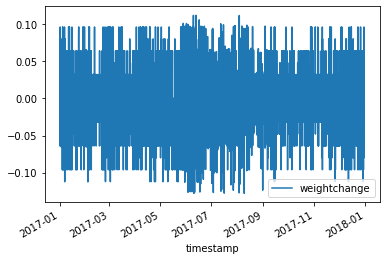

In [23]:
#Lets see the weight change graphed
#df.plot(x="timestamp", y="weightchange")

In [24]:
#Calc St. Deviation
df.std()

timestamp       106 days 15:01:58.555768862
humidity                          15.052641
min                                 8.33851
max                                9.914568
mean                               9.720369
out                               22.708402
in                                20.623549
weight                             5.703629
weightchange                       0.035765
dtype: object

In [25]:
#Values within the 50% quantile
df.quantile

<bound method DataFrame.quantile of                timestamp   humidity      min        max       mean  out   in  \
0    2017-01-01 06:00:00  92.270000  -3.3706   4.495117   1.092577  0.0  0.0   
1    2017-01-01 07:00:00  92.575000  -3.5828   4.276133   0.964174  0.0  0.0   
2    2017-01-01 08:00:00  92.840000  -3.8818   3.711483   0.824071  0.0  0.0   
3    2017-01-01 09:00:00  93.640000  -4.7422   3.108950   0.266976  0.0  0.0   
5    2017-01-01 11:00:00  92.950000  -3.4038   5.602583   0.618697  0.0  0.0   
...                  ...        ...      ...        ...        ...  ...  ...   
8732 2017-12-31 00:00:00  91.258333  10.4620  18.900333  13.899692  0.0  0.0   
8733 2017-12-31 01:00:00  90.255000  10.3460  19.169333  14.246423  0.0  0.0   
8734 2017-12-31 02:00:00  91.685000   9.9300  19.855500  14.212385  0.0  0.0   
8735 2017-12-31 03:00:00  92.323333   9.8000  19.935333  14.322692  0.0  0.0   
8736 2017-12-31 04:00:00  92.675000  10.0100  19.812000  14.597641  0.0  0.0   

   

In [26]:
#We can finally do covariance too!
df.cov()

,humidity,min,max,mean,out,in,weight,weightchange
humidity,226.582012,-99.110942,-84.852539,-103.580263,199.062211,-177.561176,-72.113371,0.035086
min,-99.110942,69.530751,64.897141,73.818313,-113.612839,102.718491,32.678953,-0.011570
max,-84.852539,64.897141,98.298668,89.930325,-94.540879,84.348185,20.805147,-0.021846
mean,-103.580263,73.818313,89.930325,94.485564,-118.053283,105.659665,31.249181,-0.026743
out,199.062211,-113.612839,-94.540879,-118.053283,515.671532,-440.420251,-65.371940,0.026474
in,-177.561176,102.718491,84.348185,105.659665,-440.420251,425.330762,57.929757,-0.007846
weight,-72.113371,32.678953,20.805147,31.249181,-65.371940,57.929757,32.531389,-0.012384
weightchange,0.035086,-0.011570,-0.021846,-0.026743,0.026474,-0.007846,-0.012384,0.001279


In [27]:
#And correlation
df.corr()

,humidity,min,max,mean,out,in,weight,weightchange
humidity,1.000000,-0.789624,-0.568563,-0.707916,0.582357,-0.571968,-0.839947,0.065173
min,-0.789624,1.000000,0.784988,0.910737,-0.600002,0.597306,0.687113,-0.038795
max,-0.568563,0.784988,1.000000,0.933146,-0.419913,0.412514,0.367913,-0.061607
mean,-0.707916,0.910737,0.933146,1.000000,-0.534821,0.527064,0.563644,-0.076926
out,0.582357,-0.600002,-0.419913,-0.534821,1.000000,-0.940410,-0.504723,0.032597
in,-0.571968,0.597306,0.412514,0.527064,-0.940410,1.000000,0.492478,-0.010637
weight,-0.839947,0.687113,0.367913,0.563644,-0.504723,0.492478,1.000000,-0.060709
weightchange,0.065173,-0.038795,-0.061607,-0.076926,0.032597,-0.010637,-0.060709,1.000000


<AxesSubplot:>

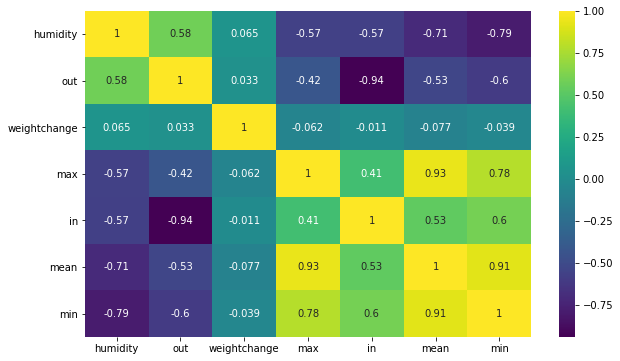

In [28]:
#Visualize correlation
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Heatmap')
    labels=['humidity', 'min', 'max', 'mean', 'out', 'in', 'weight', 'weightchange']
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    fig.colorbar(cax, ticks=[-1,-.5,0,.5,1])
    plt.show()

#Quality correlation matrix
k = 7 #number of variables for heatmap
cols = df.corr().nlargest(k, 'humidity')['humidity'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [29]:
df2 = df[["humidity","min","max","mean","out","in", "weight", 'weightchange']]

In [30]:
ss = StandardScaler()
ss.fit_transform(df2)

array([[ 1.11659415, -1.88983899, -2.25054676, ..., -0.49961956,
        -0.58931848,  0.15165925],
       [ 1.13685765, -1.91528878, -2.27263518, ..., -0.49961956,
        -0.58931848,  0.15165925],
       [ 1.15446364, -1.95114877, -2.32959032, ..., -0.49961956,
        -0.5949293 , -0.7431297 ],
       ...,
       [ 1.07772809, -0.2946573 , -0.70117505, ..., -0.49961956,
        -0.40973729,  1.94123715],
       [ 1.12013749, -0.3102486 , -0.69312242, ..., -0.49961956,
        -0.42095892, -1.63791865],
       [ 1.14350142, -0.28506265, -0.70556281, ..., -0.49961956,
        -0.42095892,  0.15165925]])

In [31]:
df2.head(20)

,humidity,min,max,mean,out,in,weight,weightchange
0,92.270000,-3.3706,4.495117,1.092577,0.0,0.0,52.6972,0.000
1,92.575000,-3.5828,4.276133,0.964174,0.0,0.0,52.6972,0.000
2,92.840000,-3.8818,3.711483,0.824071,0.0,0.0,52.6652,-0.032
3,93.640000,-4.7422,3.108950,0.266976,0.0,0.0,52.6652,0.000
5,92.950000,-3.4038,5.602583,0.618697,0.0,0.0,52.4091,-0.064
6,92.080000,-2.7678,4.588617,0.892183,0.0,0.0,52.5051,0.096
8,91.071667,-1.6358,5.755283,1.723033,0.0,0.0,52.6972,0.064
9,90.996667,-1.3362,6.023483,1.861309,0.0,0.0,52.7132,0.016
10,90.945000,-1.5696,4.980783,1.743228,0.0,0.0,52.7132,0.000
11,90.973333,-1.3320,4.869250,1.809781,0.0,0.0,52.7292,0.016


In [32]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

c:\users\cjp99\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


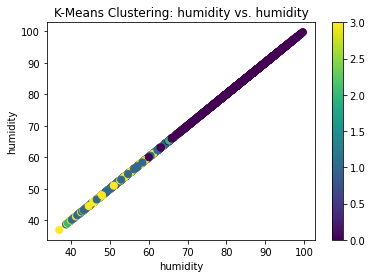

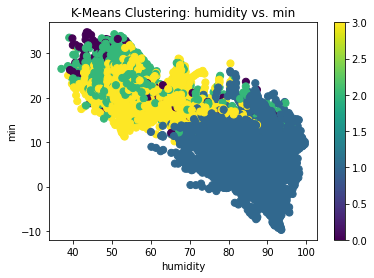

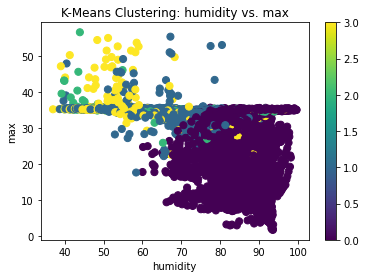

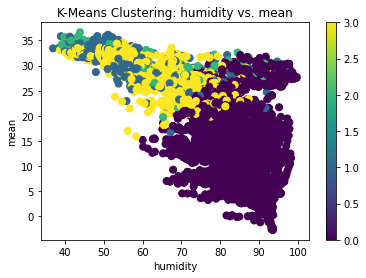

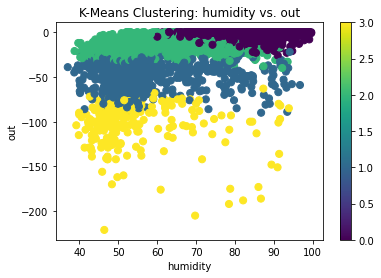

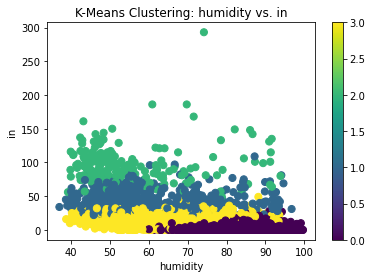

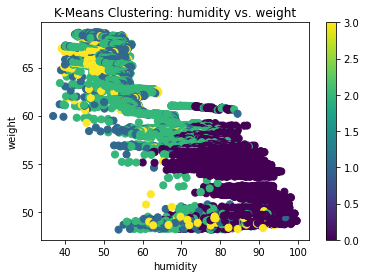

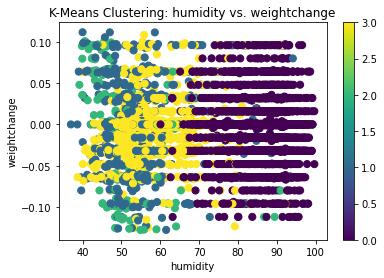

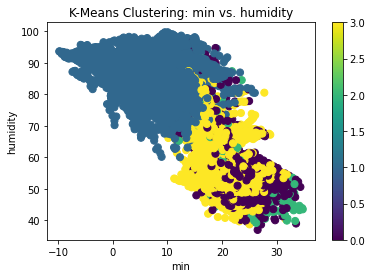

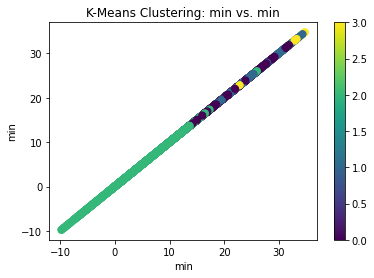

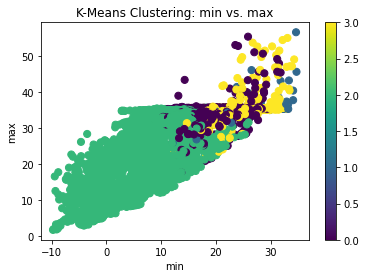

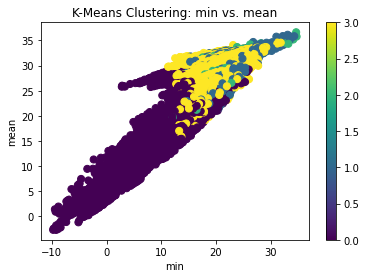

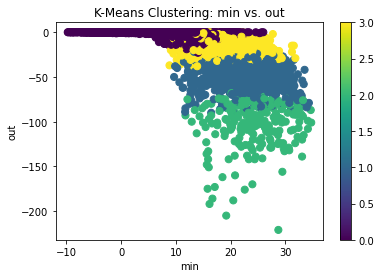

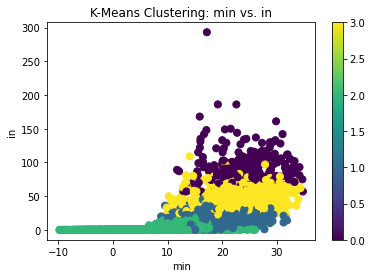

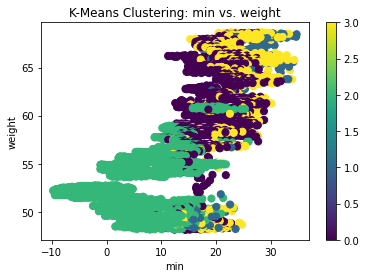

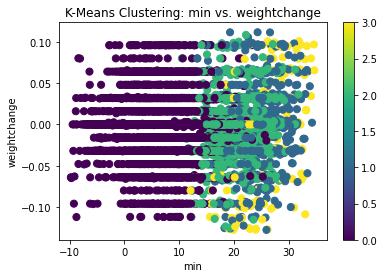

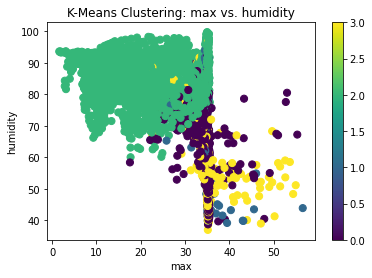

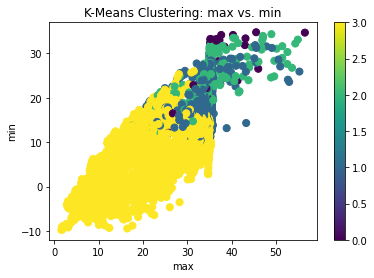

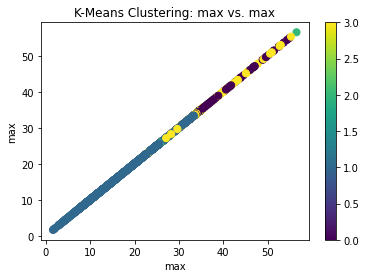

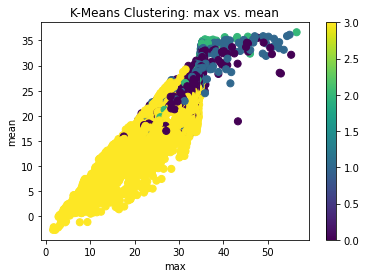

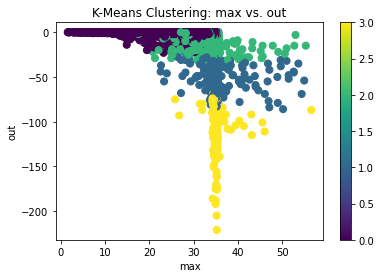

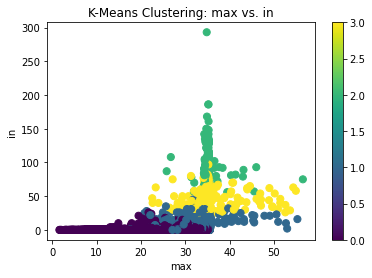

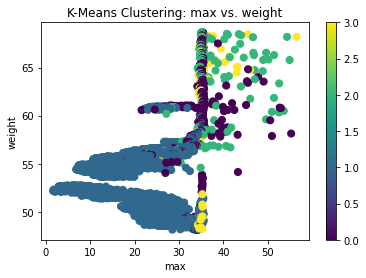

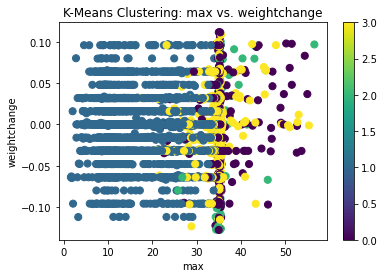

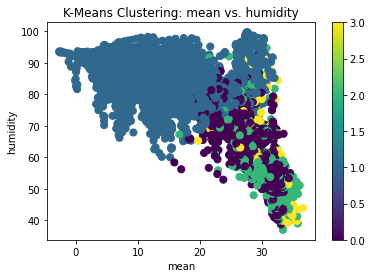

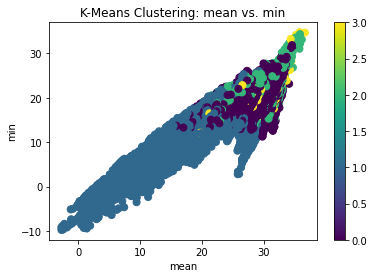

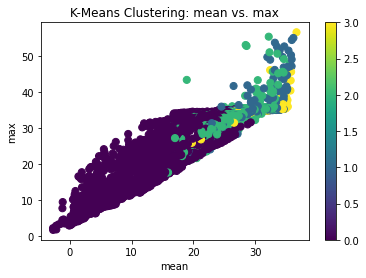

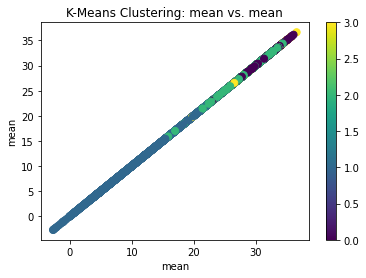

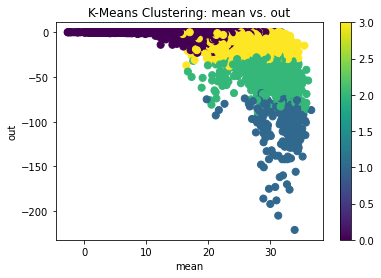

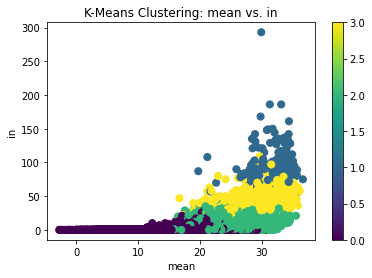

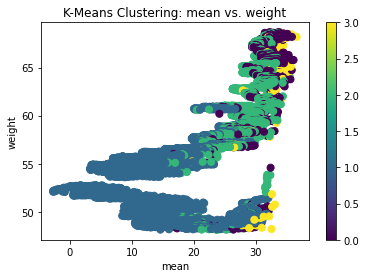

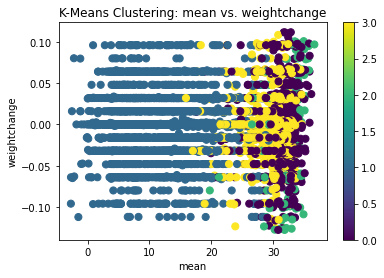

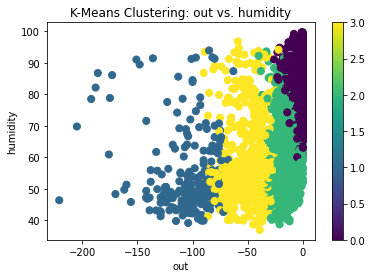

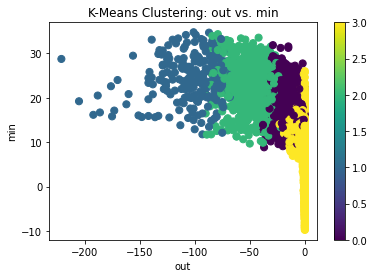

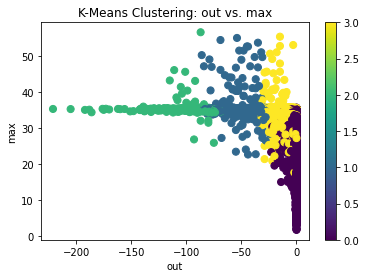

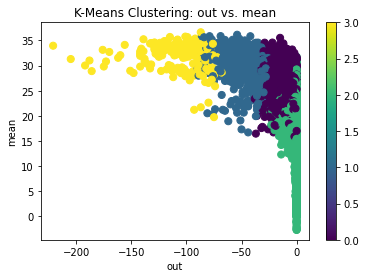

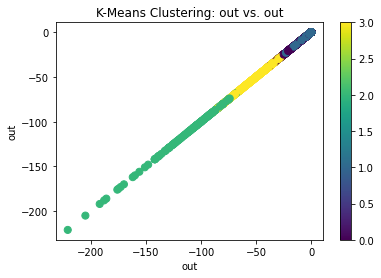

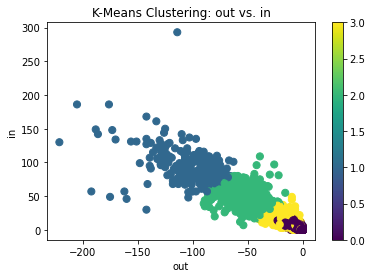

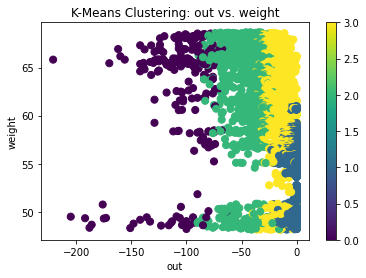

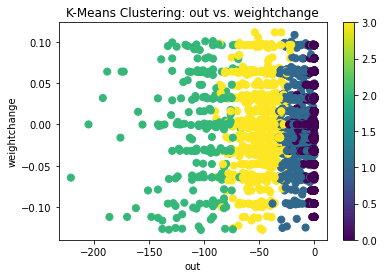

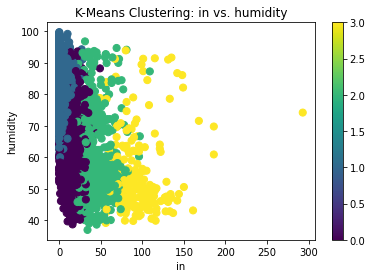

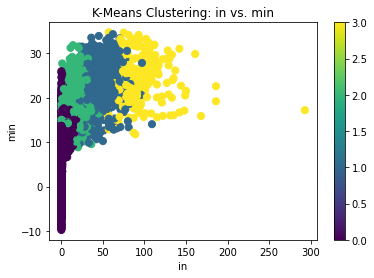

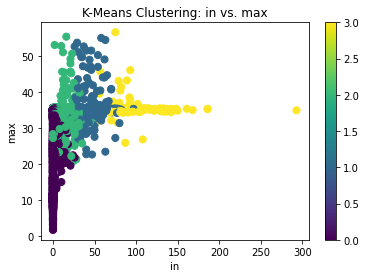

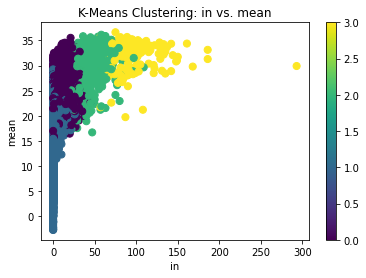

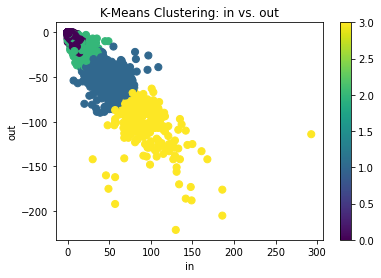

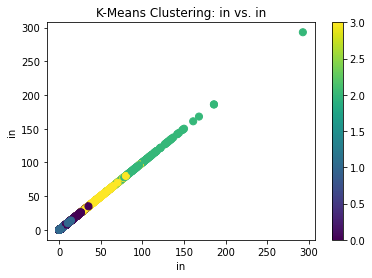

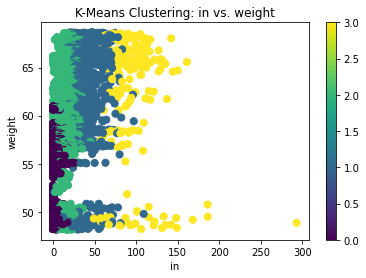

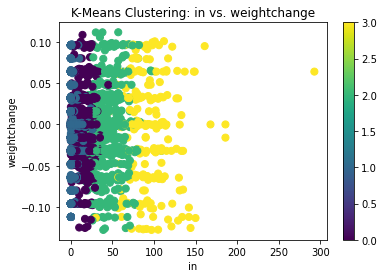

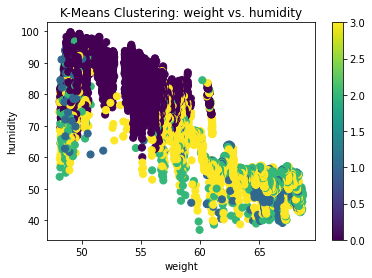

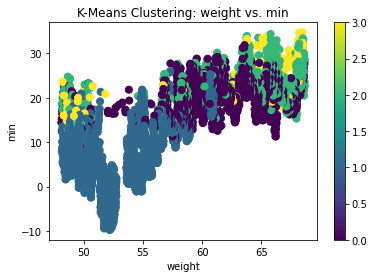

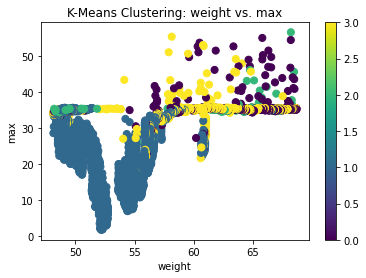

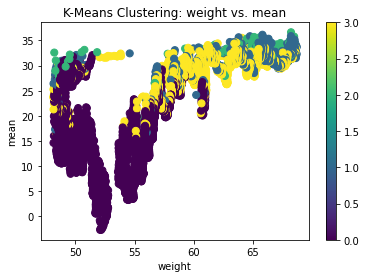

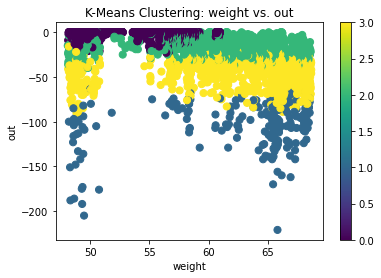

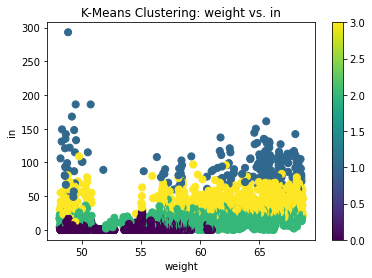

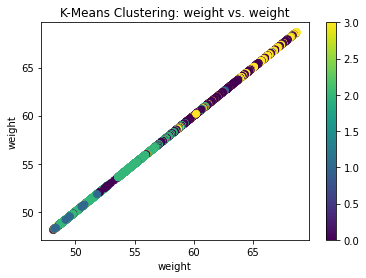

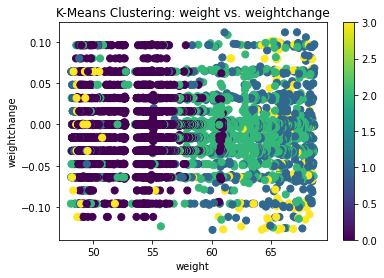

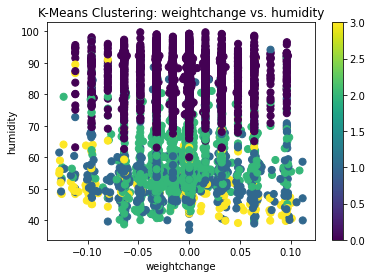

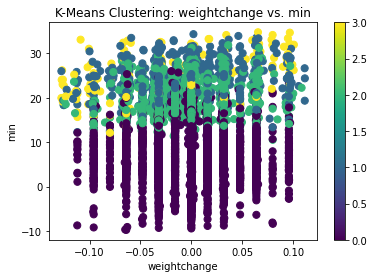

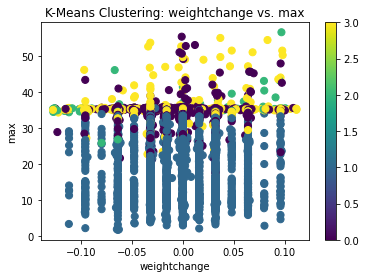

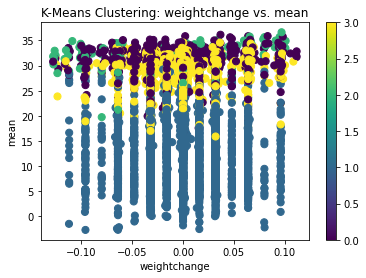

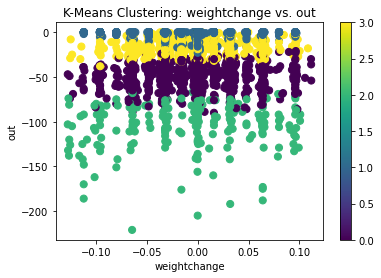

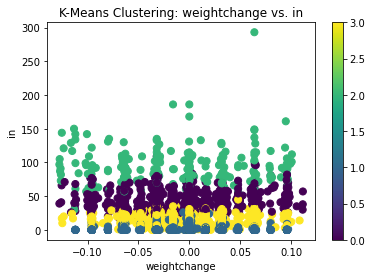

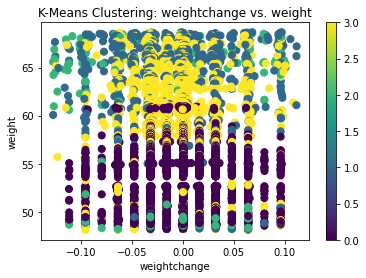

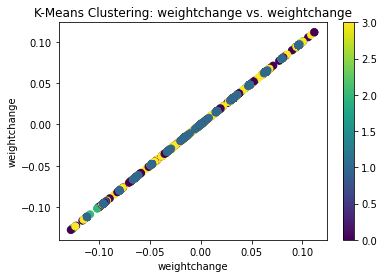

In [33]:
for col in df2:
    for col2 in df2:
        clust_labels, cent = doKmeans(df2, 4)
        kmeans = pd.DataFrame(clust_labels)
        #Plot the clusters obtained using k means
        fig = plt.figure()
        ax = fig.add_subplot(111)
        scatter = ax.scatter(df2[col],df2[col2],
                             c=kmeans[0],s=50)
        ax.set_title('K-Means Clustering: ' + col + " vs. " + col2)
        ax.set_xlabel(col)
        ax.set_ylabel(col2)
        plt.colorbar(scatter)

In [34]:
tmpdf = pd.DataFrame(df, columns=["humidity","min","max","mean","out","in", "weight", 'weightchange'])
for col in tmpdf.columns:
    print("Independent Variable: " + col)
    for col2 in tmpdf.columns:
        x = pd.DataFrame(tmpdf[col])
        y = pd.DataFrame(tmpdf[col2])
        reg = LinearRegression()
        reg.fit(x,y)
        print("Linear Regression between " + col + " and " + col2 + ": R2 score = " + str(reg.score(x,y)))
    print()

Independent Variable: humidity
Linear Regression between humidity and humidity: R2 score = 1.0
Linear Regression between humidity and min: R2 score = 0.6235063171699289
Linear Regression between humidity and max: R2 score = 0.32326346200675105
Linear Regression between humidity and mean: R2 score = 0.5011446886294513
Linear Regression between humidity and out: R2 score = 0.33914003692235206
Linear Regression between humidity and in: R2 score = 0.32714764854491196
Linear Regression between humidity and weight: R2 score = 0.7055106398580139
Linear Regression between humidity and weightchange: R2 score = 0.004247461623873461

Independent Variable: min
Linear Regression between min and humidity: R2 score = 0.623506317169929
Linear Regression between min and min: R2 score = 1.0
Linear Regression between min and max: R2 score = 0.6162069168773585
Linear Regression between min and mean: R2 score = 0.8294416562050957
Linear Regression between min and out: R2 score = 0.3600018605490757
Linear R